# Curso: Bioestatística — Análise de Covariância
## Autores: Sandro da Silva Camargo e Fernando Cardoso

**Problema**: Testar a resposta de órgãos de animais à adição de hormônios.
O abate por anestesia e usando a decapitação podem provocar respostas diferentes;
Experimento feito em 2 grupos de ratos (mesma idade e sexo): 10 animais mortos por anestesia e 10 decapitados. Os corações foram colocados no soro e a força de contração medida (Y);

A base de dados está disponível [aqui](https://github.com/Sandrocamargo/biostatistics/blob/master/datasets/ancova-ratos.txt).

Abra este código no seu google colab [clicando aqui](https://colab.research.google.com/github/Sandrocamargo/biostatistics/blob/master/python/bioe_07_Ancova.ipynb).

# Carga de pacotes

In [7]:
!pip install pingouin
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg

# Carga e inspeção dos dados

In [8]:
dados = pd.read_csv("https://raw.githubusercontent.com/Sandrocamargo/biostatistics/refs/heads/master/datasets/ancova-ratos.txt", sep=" ", decimal=",")
dados['Trt'] = dados['Trt'].astype('category')
dados.info()
dados.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Trt     20 non-null     category
 1   y       20 non-null     float64 
 2   Peso    20 non-null     float64 
dtypes: category(1), float64(2)
memory usage: 596.0 bytes


,Trt,y,Peso
0,Anestesiado,4.5,1.35
1,Anestesiado,4.6,1.30
2,Anestesiado,5.0,1.48
3,Anestesiado,4.8,1.50
4,Anestesiado,4.0,1.20


# Análise exploratória

Correlação entre y e Peso: 0.8923


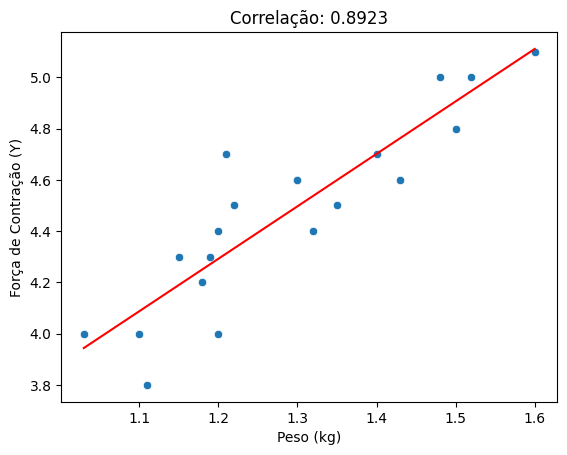

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     70.30
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           1.25e-07
Time:                        23:49:42   Log-Likelihood:                 8.4094
No. Observations:                  20   AIC:                            -12.82
Df Residuals:                      18   BIC:                            -10.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8359      0.317      5.792      0.0

In [17]:
# Correlação entre y e Peso
corr = dados['y'].corr(dados['Peso'])
print(f"Correlação entre y e Peso: {corr:.4f}")

modelo = smf.ols("y ~ Peso", data=dados).fit()
sns.scatterplot(x='Peso', y='y', data=dados)
plt.title(f"Correlação: {corr:.4f}")
sns.lineplot(x=dados['Peso'], y=modelo.fittedvalues, color='red')
plt.xlabel("Peso (kg)")
plt.ylabel("Força de Contração (Y)")
plt.show()

print(modelo.summary())

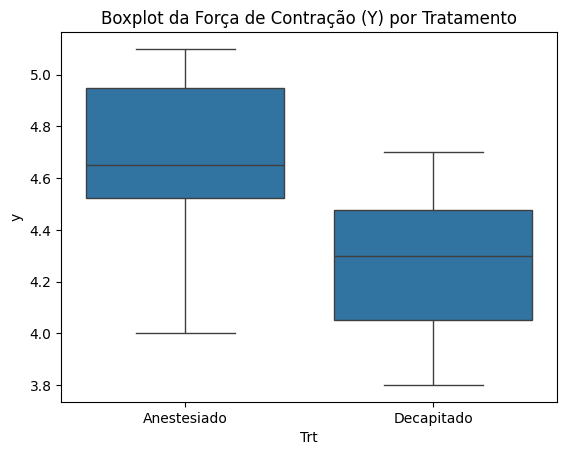

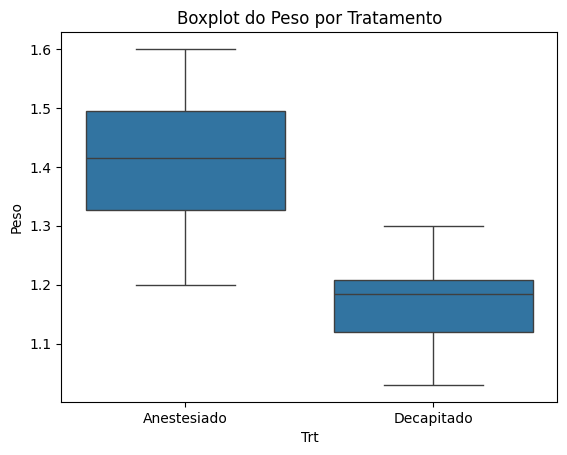


Resumo de Y por grupo:
             count  mean       std  min    25%   50%    75%  max
Trt                                                             
Anestesiado   10.0  4.67  0.330151  4.0  4.525  4.65  4.950  5.1
Decapitado    10.0  4.28  0.285968  3.8  4.050  4.30  4.475  4.7

Resumo de Peso por grupo:
             count   mean       std   min     25%    50%     75%  max
Trt                                                                  
Anestesiado   10.0  1.410  0.120000  1.20  1.3275  1.415  1.4950  1.6
Decapitado    10.0  1.169  0.075196  1.03  1.1200  1.185  1.2075  1.3


In [19]:
# Boxplots
sns.boxplot(x='Trt', y='y', data=dados)
plt.title("Boxplot da Força de Contração (Y) por Tratamento")
plt.show()

sns.boxplot(x='Trt', y='Peso', data=dados)
plt.title("Boxplot do Peso por Tratamento")
plt.show()

# Estatísticas descritivas
print("\nResumo de Y por grupo:")
print(dados.groupby('Trt', observed=False)['y'].describe())
print("\nResumo de Peso por grupo:")
print(dados.groupby('Trt', observed=False)['Peso'].describe())

# Análise de covariância

In [10]:
ancova = pg.ancova(data=dados, dv='y', covar='Peso', between='Trt')
print("\n=== Resultado da ANCOVA ===")
print(ancova)


=== Resultado da ANCOVA ===
     Source        SS  DF          F         p-unc       np2
0       Trt  0.139036   1   6.457620  2.108876e-02  0.275289
1      Peso  1.350980   1  62.747081  4.174704e-07  0.786826
2  Residual  0.366020  17        NaN           NaN       NaN


**Tratamento (Trt)**
* F = 6.46 e p = 0.021 → o efeito do tratamento é estatisticamente significativo (p < 0.05).
* Isso significa que, mesmo após controlar o efeito do peso, ainda há diferença significativa entre os grupos de tratamento quanto à variável dependente (ex: força de contração).
* O eta quadrado parcial (η²p = 0.275) indica um efeito de tamanho moderado: aproximadamente 27,5% da variação ajustada pode ser atribuída ao tratamento.

**Covariável (Peso)**
* F = 62.75 e p < 0.000001 → o peso tem forte efeito sobre a variável dependente.
* O eta quadrado parcial (η²p = 0.787) indica um efeito muito grande: cerca de 78,7% da variação ajustada está associada à covariável.

**Resíduos**
* Representam a variação não explicada pelo modelo.
* Essa soma de quadrados (SS = 0.366) é relativamente pequena, o que reforça que o modelo explica bem os dados.

**📈 Conclusão geral**
* O peso tem forte influência sobre a variável resposta.
* Mesmo controlando o peso, o tratamento ainda exerce um efeito significativo.
* O modelo como um todo explica grande parte da variabilidade dos dados.

# Ajuste de médias

In [20]:
# Calcula médias ajustadas via modelo linear
modelo_ancova = smf.ols('y ~ Peso + Trt', data=dados).fit()
print("\n=== Modelo ANCOVA ===")
print(modelo_ancova.summary())

# Médias ajustadas por tratamento
em_means = dados.copy()
em_means['ajustado'] = modelo_ancova.fittedvalues
print("\nMédias ajustadas por tratamento:")
print(em_means.groupby('Trt', observed=False)['ajustado'].mean())


=== Modelo ANCOVA ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     49.03
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           8.72e-08
Time:                        23:54:12   Log-Likelihood:                 11.629
No. Observations:                  20   AIC:                            -17.26
Df Residuals:                      17   BIC:                            -14.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept      

**Qual o objetivo da análise?**
* A ANCOVA busca verificar se há diferença entre os grupos de tratamento na variável y, controlando o efeito do peso.
* Em outras palavras: queremos saber se o tratamento afeta y independentemente do peso dos animais.

**📊 2. Qualidade geral do modelo**
* R² = 0.852 → o modelo explica 85,2% da variação total em y, o que é excelente.
* R² ajustado = 0.835 → mesmo considerando o número de preditores, o modelo mantém boa capacidade explicativa.
* F(2,17) = 49.03, p = 8.72×10⁻⁸ → o modelo global é altamente significativo, ou seja, peso e tratamento, em conjunto, explicam de forma robusta a variação em y.

**⚙️ 3. Interpretação dos coeficientes**
|Termo	|Coef.	|Interpretação|
|:--|:--|:--|
|Intercepto |= 0.8124	|Valor esperado de y para o grupo Anestesiado, quando Peso = 0 (interpretação matemática, não biológica).	|
|Trt[T.Decapitado] = 0.2693, |p = 0.021	|O grupo Decapitado apresenta, em média, +0.27 unidades maiores de y do que o grupo Anestesiado, ajustando o efeito do peso. Como p < 0.05, essa diferença é estatisticamente significativa.	|
|Peso = 2.7359, |p < 0.001	|A cada aumento de 1 unidade de peso, há um acréscimo médio de 2.74 unidades em y, mantendo o tratamento constante. O efeito do peso é forte e altamente significativo.	|

**⚖️ 4. Médias ajustadas (ANCOVA)**
* As médias ajustadas representam os valores de y esperados para cada grupo de tratamento, corrigidos pelo efeito do peso.

|Tratamento	|Média ajustada de y|
|:--|:--|
|Anestesiado	|4.67|
|Decapitado	|4.28|

* ➡️ Embora o coeficiente positivo de “Decapitado” sugira maior valor inicial, após o ajuste pela covariável (peso), o grupo Anestesiado apresenta média ligeiramente maior (4.67 vs 4.28).

* Isso indica que parte da diferença bruta entre grupos era explicada pelo peso  e, após o controle, a diferença se reduz.

**📈 5. Pressupostos**
* Durbin-Watson = 2.19 → ausência de autocorrelação dos resíduos (bom sinal).
* Teste de normalidade (Omnibus, JB): p > 0.05 → resíduos aproximadamente normais.
* Cond. No. = 31.5 → sem problemas sérios de multicolinearidade.

**🧩 Conclusão**
* O peso exerce forte influência sobre y.
* O tratamento ainda tem efeito significativo mesmo após controlar o peso (p = 0.021).
* O modelo ajustado explica muito bem os dados.
* As médias ajustadas indicam pequenas diferenças entre os grupos, o que reforça a utilidade da ANCOVA: separar o efeito do tratamento do efeito da covariável.

# Teste de pressupostos


Shapiro-Wilk para resíduos:
ShapiroResult(statistic=np.float64(0.96599191200068), pvalue=np.float64(0.6690113873053192))


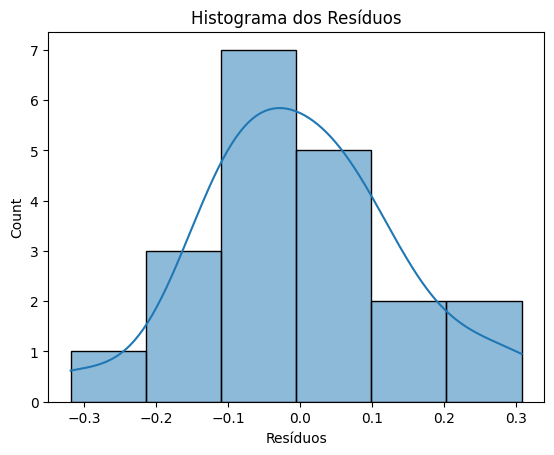


Bartlett test:
BartlettResult(statistic=np.float64(0.1753929866154209), pvalue=np.float64(0.6753627004737937))

Levene test:
LeveneResult(statistic=np.float64(0.13149350649350636), pvalue=np.float64(0.7211113933256456))


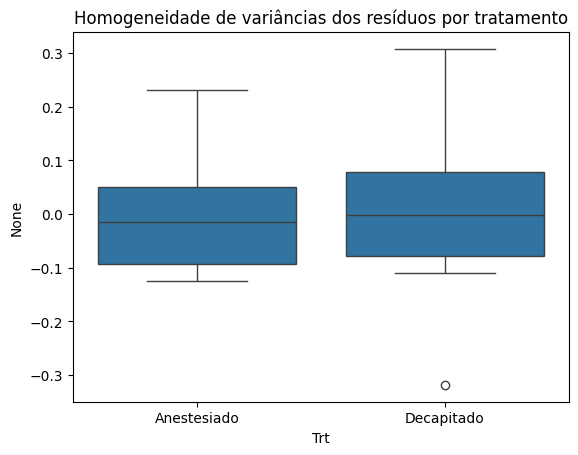

In [12]:
# Normalidade dos resíduos
residuos = modelo_ancova.resid
print("\nShapiro-Wilk para resíduos:")
print(stats.shapiro(residuos))

sns.histplot(residuos, kde=True)
plt.title("Histograma dos Resíduos")
plt.xlabel("Resíduos")
plt.show()

# Homogeneidade de variâncias
print("\nBartlett test:")
print(stats.bartlett(*[dados.loc[dados.Trt == g, 'y'] for g in dados.Trt.unique()]))

print("\nLevene test:")
print(stats.levene(*[dados.loc[dados.Trt == g, 'y'] for g in dados.Trt.unique()]))

sns.boxplot(x='Trt', y=residuos, data=dados)
plt.title("Homogeneidade de variâncias dos resíduos por tratamento")
plt.show()

In [13]:
# ==========================================================
# 6. Interação (homogeneidade dos coeficientes angulares)
# ==========================================================
modelo_interacao = smf.ols('y ~ Trt * Peso', data=dados).fit()
anova_interacao = sm.stats.anova_lm(modelo_interacao, typ=3)
print("\n=== Teste de interação Tratamento*Peso ===")
print(anova_interacao)


=== Teste de interação Tratamento*Peso ===
             sum_sq    df          F    PR(>F)
Intercept  0.069540   1.0   3.139158  0.095474
Trt        0.004301   1.0   0.194137  0.665390
Peso       0.860772   1.0  38.856696  0.000012
Trt:Peso   0.011580   1.0   0.522751  0.480107
Residual   0.354439  16.0        NaN       NaN


**Estrutura geral**

O modelo testou o efeito do Tratamento (Trt), da covariável Peso e da interação entre ambos (Trt:Peso) sobre a variável dependente y.
O objetivo é verificar:
* se o tratamento tem efeito sobre y,
* se o peso influencia y,
* e se o efeito do tratamento depende do peso (interação).

**Interpretação dos resultados**
|Fonte|	F	|p (PR(>F))	|Interpretação|
|:--|:--|:--|:--|
|Intercept	|3.14	|0.095	|O intercepto não é estatisticamente diferente de zero (sem relevância prática isolada).|
|Trt	|0.19	|0.665	|O tratamento não tem efeito significativo sobre y após controlar pelo peso.|
|Peso	|38.86	|< 0.001	|O peso tem forte efeito significativo sobre y. À medida que o peso aumenta, y também tende a aumentar.|
|Trt:Peso|	0.52	|0.480	|A interação não é significativa. O efeito do peso sobre y é semelhante entre os tratamentos.|
|Residual	|—	|—	|Variabilidade não explicada pelo modelo.|

**Conclusão prática**
* O peso é a principal variável associada a y (efeito forte e significativo).
* O tratamento, por si só, não altera significativamente o valor de y.
* A relação entre peso e y é paralela entre os grupos (sem interação significativa).
* Portanto, um modelo sem interação (modelo aditivo) é mais parcimonioso e apropriado.

# Regressões separadas por grupo

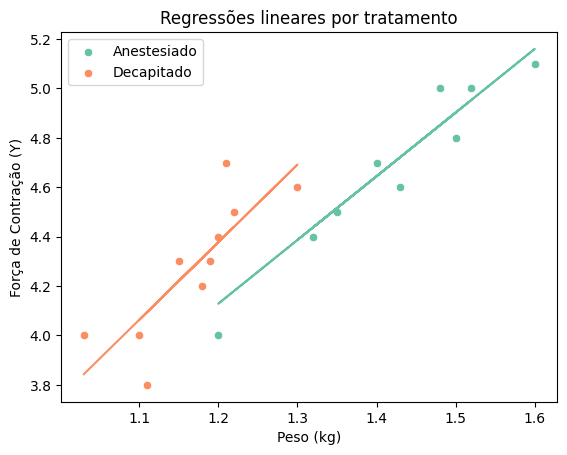

In [14]:
plt.figure()
cores = sns.color_palette("Set2", n_colors=len(dados.Trt.cat.categories))
for i, trt in enumerate(dados.Trt.cat.categories):
    subset = dados[dados.Trt == trt]
    sns.scatterplot(x='Peso', y='y', data=subset, color=cores[i], label=trt)
    modelo = smf.ols('y ~ Peso', data=subset).fit()
    plt.plot(subset['Peso'], modelo.fittedvalues, color=cores[i])
plt.legend()
plt.title("Regressões lineares por tratamento")
plt.xlabel("Peso (kg)")
plt.ylabel("Força de Contração (Y)")
plt.show()